# Classificação

Testes iniciais de classificação de documentos. O objetivo desse notebook é explorar algumas possibilidades de classficaição de documentos e encontrar um *baseline* para ser explorado posteriormente.

In [366]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import nltk
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sn

from text.process import text_processor

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
    
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
RANDOM_STATE = 42


In [421]:
DATAFRAME_PATH = '/home/cti/workspace/cls_documento/dataset/output/dataframe.csv'


df = pd.read_csv(DATAFRAME_PATH)

# Remove documentos da parte técnica
df = df[ (df['tipo'] != 'Características técnicas') & (df['tipo'] != 'Planilha de orçamento - Ganhadora')] 

df['texto'] = df['texto'].astype(str).apply(lambda x: x.replace("\n", " "))
df['texto_limpo'] = df['texto'].astype(str).apply(text_processor.clear_words)
df['texto_stemmed'] = df['texto_limpo'].astype(str).apply(text_processor.stem_sentence)
df['texto_len'] = df['texto'].astype(str).apply(len)
df['texto_limpo_len'] = df['texto_limpo'].astype(str).apply(len)
df['texto_stemmed_len'] = df['texto_stemmed'].astype(str).apply(len)
df['qtd_palavras_texto'] = df['texto'].apply(lambda x: len(str(x).split()))
df['qtd_palavras_texto_limpo'] = df['texto_limpo'].apply(lambda x: len(str(x).split()))
df['qtd_palavras_texto_stemmed'] = df['texto_stemmed'].apply(lambda x: len(str(x).split()))

df.sample(5)

Unnamed: 0                                    projeto  \
163         163            Icaraíma - proj 50 - processo 1   
120         120               Fênix - proj 35 - processo 1   
329         329  São Carlos do Ivaí - proj 28 - processo 1   
320         320           Sertaneja - proj 35 - processo 1   
169         169            Icaraíma - proj 50 - processo 1   

                                                 texto  \
163  PREFEITURA MUNICIPAL DE ICARAÍMA ESTADO DO PAR...   
120  PREFEITURA DO MUNICIPIO DE FENIX ESTADO DO PAR...   
329  PREFEITURA DO MUNICÍPIO DE SÃO CARLOS DO IVAÍ ...   
320  MUNICÍPIO DE SERTANEJA RELATÓRIO  REF: EDITAL ...   
169  |  - ESTADO DO PARANÁ -  AV. HERMES VISSOTO, 8...   

                                                  tipo  \
163  Declaração das proponentes declinando do prazo...   
120                              Edital de habilitação   
329                 Relatórios do Processo Licitatório   
320                 Relatórios do Processo Licitatório   
169                     Parecer Juridico minuta edital   

                                           texto_limpo  \
163  prefeitura municipal icaraíma estado paraná cn...   
120  prefeitura municipio fenix estado parana depar...   
329  prefeitura município carlos ivaí estado paraná...   
320  município sertaneja relatório ref edital pregã...   
169  estado paraná hermes vissoto 810 centro fone/f...   

                                         texto_stemmed  texto_len  \
163  prefeit municip icaraím est paran cnpj 247 337...        747   
120  prefeit municipi fenix est paran departament l...        998   
329  prefeit municípi carl ivaí est paran arlosdoiv...       3707   
320  municípi sertanej relatóri ref edit preg eletr...       3281   
169  est paran herm vissot 810 centr fone/fax 044 3...       2838   

     texto_limpo_len  texto_stemmed_len  qtd_palavras_texto  \
163              561                441                  98   
120              745                588                 146   
329             2613               2030                 544   
320             2438               1876                 474   
169             2015               1556                 488   

     qtd_palavras_texto_limpo  qtd_palavras_texto_stemmed  
163                        63                          63  
120                        84                          84  
329                       311                         311  
320                       290                         290  
169                       255                         255

In [393]:
from nltk.corpus import floresta
from nltk.stem.snowball import PorterStemmer

# text = text_processor.clear_words(df.iloc[0].texto)
# print( len(set(floresta.words())) )
# print( len(floresta.words()) )

df.iloc[0].texto_stemmed
# text_processor.stem_token('prefeitura')
# stemmer = PorterStemmer()


'prefeit municip alt paraiso-pr cnaj95 640 736/0001-30 cep 87528-000 pedr amar sant 900 fone/fax oxx 3664 1320 e-mail altoparais dpref gov port 152/2019 dat 03/04/2019 autor execu municip súmul nome prego alt equip apoi municípi parais exercíci 2019 prefeit municip alt paraís est paran uso atribu legal resolv nome compor equip apoio-d municípi alo paraís fim de-oferec suport pár prego municípi nome pesso abaix relacion cam spo qro pregogir valdem rib sporápor cpfnº005876 549-29 secret uesl gonçalv rodrigues-d silv cpf 066 334 889-7 merhbr cinih loiz zagot cpf 018315 769-96 ri mad oliv caet cpf 034 210 259= marild ros nasc silv cpf 033 220 759-58 esquin tot port vig ano part dat fic revog port 013/2019 port entr emvig dat +15 sot felici prgjeiídc municip alt parais est paran trê dias-d mê abh 2019 eia ntoven mus éipal 1g jorn'

## Testes com texto puro

Testes feitos com diferentes classificadores com o texto puro, sem remoção de stopwords, nem qualquer outro tipo de preprocessamento. 

O dataset é dividido em 80/20, com os tipos de documento sendo transformados em labels númericas. O corpo do texto é transformado forma numérica pelo TF. São consideradas apenas tokens com tamanho maior ou igual a 3.

In [394]:
encoder = LabelEncoder()
# encoder = OneHotEncoder()
X = df.texto.values
y = encoder.fit_transform(df.tipo.values)

vectorizer = CountVectorizer(token_pattern=r'\w{3,}')
vectorizer.fit( X )
X = vectorizer.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(304, 44812)
(304,)
(76, 44812)
(76,)


In [5]:

word_freq_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)

top_words_df.head()

0
2020    5861
que     3954
para    3481
com     3264
edital  2674

In [396]:
 
classifier = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)  
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6316
Precision score: 0.6316
Recall score: 0.6316
[[ 9  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  1  0  1  0]
 [ 0  0  4  0  0  0  0  0  0  0  2  0]
 [ 1  0  0  0  4  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  7  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  3  4  0  0  0  0]
 [ 0  0  0  0  0  0  4  1  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  1  0  0  6]]


In [395]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.5789
Precision score: 0.5789
Recall score: 0.5789
[[ 9  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  1  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  1  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  7  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  3  4  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  4  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  1  0  0  5]]


In [397]:
classifier = SVC()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.5526
Precision score: 0.5526
Recall score: 0.5526
[[ 5  0  2  0  1  0  0  0  0  0  0  2]
 [ 0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  1  0  0  0  0  1  0  2]
 [ 0  0  1  0  0  0  0  0  0  1  0  1]
 [ 0  0  1  0  0  7  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  2  1  0  0  0  0]
 [ 0  0  3  0  0  0  4  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  6]]


### Resultados preliminares

Utilizando a frequencia dos termos direntamente sobre o texto original, o melhor modelos obtido foi a RandomForest, obtendo uma Acurácia de 0.6883, seguida do modelo Bays com uma acurácia de 0.5455 e por fim uma SVM com acurácia de 0.5065.

## Teste com o texto limpo

Os testes a seguir serão aplicados sobre o conjunto de dados, divididos em 80/20, após um pré-processamento do texto. Será utilizado apenas o TF como feature principal.

In [398]:
encoder = LabelEncoder()
# encoder = OneHotEncoder()
X = df.texto_limpo.values
y = encoder.fit_transform(df.tipo.values)

vectorizer = CountVectorizer(token_pattern=r'\w{3,}')
vectorizer.fit( X )
X = vectorizer.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(304, 44587)
(304,)
(76, 44587)
(76,)


In [399]:

word_freq_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)

top_words_df.head()

0
2020       5277
edital     2415
municipal  2066
licitação  1975
objeto     1490

In [403]:
 
classifier = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)  
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6447
Precision score: 0.6447
Recall score: 0.6447
[[ 9  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0  0  0  0  1  0]
 [ 0  0  4  0  0  0  0  0  0  0  2  0]
 [ 1  0  0  0  4  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  7  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  3  4  0  0  0  0]
 [ 0  0  0  0  0  0  4  2  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  1  0  0  6]]


In [401]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.5921
Precision score: 0.5921
Recall score: 0.5921
[[ 9  0  0  0  1  0  0  0  0  0  0  0]
 [ 2  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  2  0  1]
 [ 0  0  0  1  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  7  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  3  4  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  4  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0]
 [ 1  0  0  0  0  0  0  0  1  0  0  6]]


In [402]:
classifier = SVC()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.5132
Precision score: 0.5132
Recall score: 0.5132
[[ 5  0  2  0  1  0  0  0  0  0  0  2]
 [ 0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0]
 [ 2  0  1  0  1  0  0  0  0  1  0  1]
 [ 0  0  1  0  0  0  0  0  0  1  0  1]
 [ 0  0  1  0  0  7  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  2  1  0  0  0  0]
 [ 0  0  4  0  0  0  3  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  6]]


## Resultados preliminares

Observando os resultados sobre os textos sem as stopwors é possível ver que houve uma leve queda no desempenho da Random Forest, obtendo uma acurácia de 0.6753. Já os outros classificadores sofreram uma melhora em seu desempenho, com o modelo Bayseano obtendo uma acurácia de 0.5325 e a SVM obtendo uma acurácia de 0.4805.

## Texto Stemmed

Testes com o texto sem stopwords após o stemming

In [404]:
encoder = LabelEncoder()
X = df.texto_stemmed.values
y = encoder.fit_transform(df.tipo.values)

vectorizer = CountVectorizer(token_pattern=r'\w{3,}')
vectorizer.fit( X )
X = vectorizer.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(304, 35084)
(304,)
(76, 35084)
(76,)


In [325]:

word_freq_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)

top_words_df.head()

0
2020     5861
licit    3529
contrat  3353
edit     2730
municip  2422

In [329]:
 
classifier = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)  
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6753
Precision score: 0.6753
Recall score: 0.6753
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  1  2  0  0  0  0  0  1  0  1]
 [ 1  0  0  0  2  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  0  0  1  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6]]


In [405]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.5132
Precision score: 0.5132
Recall score: 0.5132
[[ 8  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  1  0  0  1  0  0  0  1  0  0]
 [ 0  0  5  0  0  0  0  0  0  1  0  0]
 [ 4  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  7  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  3  0  1  0  0]
 [ 0  0  0  0  0  0  5  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  2  5  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  2  0  0  0  1  0  4]]


In [406]:
classifier = SVC()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.5263
Precision score: 0.5263
Recall score: 0.5263
[[ 5  0  2  0  1  0  0  0  0  0  0  2]
 [ 0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  1  0  0  0  0  1  0  2]
 [ 0  0  1  0  0  0  0  0  0  1  0  1]
 [ 0  0  1  0  0  7  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  2  1  0  0  0  0]
 [ 0  0  4  0  0  0  3  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0  5]]


## TF-IDF

Os modelos acima utilizaram apenas a frequencia dos termos como *feature* básica. Os tópicos abaixo exploram o TF-IDF como feature, verificando se há melhoras nos modelos.

In [407]:
encoder = LabelEncoder()
# encoder = OneHotEncoder()
X = df.texto.values
# y = encoder.fit_transform(df[['tipo']])
y = encoder.fit_transform(df.tipo.values)


vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', max_features=5000)
vectorizer.fit( X )
X = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(304, 5000)
(304,)
(76, 5000)
(76,)


In [101]:

word_freq_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)

top_words_df.head()

0
2020    29.190539
que     24.074612
para    19.162532
edital  18.738418
com     17.310131

In [102]:
 
classifier = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)  
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6494
Precision score: 0.6494
Recall score: 0.6494
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  2  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  1  3  0  0  0  0  0  0  0  1]
 [ 1  0  0  0  2  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  2  0  0  0  1  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6]]


In [408]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6053
Precision score: 0.6053
Recall score: 0.6053
[[ 6  0  0  0  0  0  0  0  0  0  0  4]
 [ 0  0  1  0  0  1  0  0  0  0  0  1]
 [ 0  0  6  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  2  0  1]
 [ 0  0  0  0  0  0  0  0  1  2  0  0]
 [ 0  0  0  0  0  7  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  3  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0  0  6]]


In [409]:
classifier = SVC()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6711
Precision score: 0.6711
Recall score: 0.6711
[[ 9  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  2  0  0  0  0  1  0  0]
 [ 0  0  0  1  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  7  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  3  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  1  0  0  6]]


## Resultados Preliminares

A Random Forest obteve uma acurácia de 0.6494, enquanto o modelo bayseano 0.5974 e a SVM 0.6494.

## TF-IDF com o Texto Limpo


In [410]:
encoder = LabelEncoder()
# encoder = OneHotEncoder()
X = df.texto_limpo.values
# y = encoder.fit_transform(df[['tipo']])
y = encoder.fit_transform(df.tipo.values)


vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', max_features=5000)
vectorizer.fit( X )
X = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(304, 5000)
(304,)
(76, 5000)
(76,)


In [116]:

word_freq_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)

top_words_df.head()

0
edital     20.329443
licita     19.660376
rio        18.376683
ncia       15.989347
municipal  15.099688

In [117]:
 
classifier = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)  
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6623
Precision score: 0.6623
Recall score: 0.6623
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  2  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  1  3  0  0  0  0  0  0  0  1]
 [ 1  0  0  0  2  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  8  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6]]


In [411]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6053
Precision score: 0.6053
Recall score: 0.6053
[[ 6  0  0  0  0  0  0  0  0  0  0  4]
 [ 0  0  1  0  0  0  0  0  0  0  0  2]
 [ 0  0  6  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  2  0  1]
 [ 0  0  0  0  0  0  0  0  1  2  0  0]
 [ 0  0  0  0  0  7  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  3  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0  0  6]]


In [412]:
classifier = SVC()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6447
Precision score: 0.6447
Recall score: 0.6447
[[ 9  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  4  0  0  0  0  0  0  0  2  0]
 [ 3  0  0  0  2  0  0  0  0  1  0  0]
 [ 0  0  0  1  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  7  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  3  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  1  0  0  6]]


### Resultados Pre-liminares

Ao utílizar o TF-IDF com o testo limpo o Random Forest continua a performar pior do que ao utilizar apenas o TF do texto puro, obtendo 0.6753 de acurácia, o modelo Naive Bayse obteve uma acurácia de 0.5844, enquanto a SVM obteve seu melhor resultado até o momento, com 0.6364 de acurácia.

## Bi-gram como Feature

Explorando o Bi-grama de tokens com tamanho 3 ou maiores como features para o classificador.

In [138]:
encoder = LabelEncoder()
# encoder = OneHotEncoder()
X = df.texto.values
y = encoder.fit_transform(df.tipo.values)


vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', ngram_range=(2,3), max_features=5000)
vectorizer.fit( X )
X = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [139]:

word_freq_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)

top_words_df.head()

0
estado paraná         9.555907
prefeitura municipal  8.741574
março 2020            7.929790
lei 666               6.900018
comissão licitação    6.576372

In [9]:
 
classifier = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)  
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6883
Precision score: 0.6883
Recall score: 0.6883
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  2  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  1  3  0  0  0  0  0  0  0  1]
 [ 1  0  0  0  2  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  0  0  1  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6]]


In [141]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6104
Precision score: 0.6104
Recall score: 0.6104
[[9 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 2 0 0 0 0 0 0 0 1 0 1]
 [0 0 9 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 2 0 0 0 0 0 1 0 1]
 [2 0 0 2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 4 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 3 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 7 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 6]]


In [142]:
classifier = SVC()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6104
Precision score: 0.6104
Recall score: 0.6104
[[10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  1  3  0  0  0  0  0  0  0  1]
 [ 2  0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  3  0  0  0  0  0]
 [ 1  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  5]]


## Bi-gram como Feature - Texto Limpo

Explorando o Bi-grama de tokens com tamanho 3 ou maiores como features para o classificador.

In [143]:
encoder = LabelEncoder()
# encoder = OneHotEncoder()
X = df.texto_limpo.values
y = encoder.fit_transform(df.tipo.values)


vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', ngram_range=(2,3), max_features=5000)
vectorizer.fit( X )
X = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [146]:

word_freq_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)

top_words_df.head()

0
estado paraná         10.055446
prefeitura municipal   9.199705
março 2020             8.381808
lei 666                7.323018
comissão licitação     7.056903

In [147]:
 
classifier = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)  
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6494
Precision score: 0.6494
Recall score: 0.6494
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  2  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  1  3  0  0  0  0  0  0  0  1]
 [ 1  1  0  0  2  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6]]


In [148]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6104
Precision score: 0.6104
Recall score: 0.6104
[[9 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 2 0 0 0 0 0 0 0 2 0 1]
 [0 0 9 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 2 0 0 0 0 0 1 0 1]
 [2 0 0 2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 4 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 3 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 7 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 6]]


In [149]:
classifier = SVC()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

cm = confusion_matrix(y_test, predictions)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print(cm)

Accuracy score: 0.6104
Precision score: 0.6104
Recall score: 0.6104
[[10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  1  3  0  0  0  0  0  0  0  1]
 [ 2  0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  3  0  0  0  0  0]
 [ 1  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  5]]


## RNA

Modelo de uma Rede Neural Artificial de teste para a classificação.

In [420]:
from keras.models import Sequential
from keras import layers

df.tipo.unique()

array(['Portaria designando a comissão de licitação',
       'Edital do Processo Licitatório',
       'Publicações do aviso do Processo Licitatório',
       'Atas do Processo Licitatório',
       'Relatórios do Processo Licitatório',
       'Parecer Juridico minuta edital',
       'Declaração de inexistência de recursos',
       'Declaração das proponentes declinando do prazo recursal',
       'Recursos do Processo Licitatório', 'Edital de habilitação',
       'Edital de classificação', 'Parecer Jurídico do Município',
       'Planilha de orçamento - Ganhadora'], dtype=object)

In [480]:
# encoder = LabelEncoder()
encoder = OneHotEncoder(sparse=False)
X = df.texto_limpo.values
# X = df.texto_stemmed.values
y = encoder.fit_transform(df.tipo.values.reshape(len(df.tipo.values), 1))

# vectorizer = CountVectorizer(token_pattern=r'\w{3,}')
# vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', ngram_range=(2,3), max_features=5000)
vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', max_features=5000)
vectorizer.fit( X )
X = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

input_dim = X_train.shape[1]

In [490]:

model = Sequential()
model.add(layers.Dense(16, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())


# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.BatchNormalization())

model.add(layers.Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 16)                80016     
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16)                64        
_________________________________________________________________
dense_135 (Dense)            (None, 12)                204       
Total params: 80,284
Trainable params: 80,252
Non-trainable params: 32
_________________________________________________________________


In [491]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Train on 303 samples, validate on 76 samples
Epoch 1/50
303/303 [==============================] - 1s 4ms/step - loss: 2.2971 - acc: 0.2211 - val_loss: 2.4513 - val_acc: 0.4474
Epoch 2/50
303/303 [==============================] - 0s 127us/step - loss: 1.5924 - acc: 0.5842 - val_loss: 2.4085 - val_acc: 0.5263
Epoch 3/50
303/303 [==============================] - 0s 121us/step - loss: 1.3112 - acc: 0.7030 - val_loss: 2.3723 - val_acc: 0.5789
Epoch 4/50
303/303 [==============================] - 0s 137us/step - loss: 1.1063 - acc: 0.7360 - val_loss: 2.3471 - val_acc: 0.6184
Epoch 5/50
303/303 [==============================] - 0s 135us/step - loss: 0.9729 - acc: 0.8119 - val_loss: 2.3235 - val_acc: 0.6184
Epoch 6/50
303/303 [==============================] - 0s 128us/step - loss: 0.8930 - acc: 0.8251 - val_loss: 2.2992 - val_acc: 0.6184
Epoch 7/50
303/303 [==============================] - 0s 129us/step - loss: 0.8175 - acc: 0.8416 - val_loss: 2.2776 - val_acc: 0.6184
Epoch 8/50
303/303 

Plotando graficos: Acc


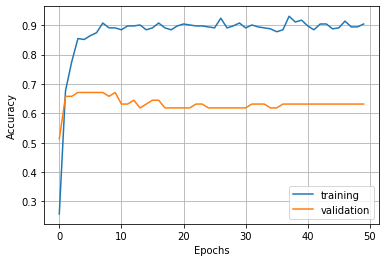

In [487]:
print('Plotando graficos: Acc')
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


Plotando graficos: Loss


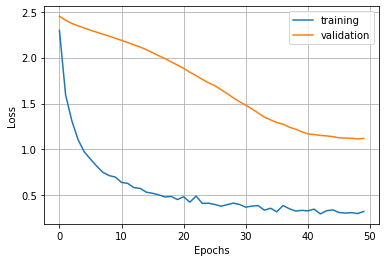

In [492]:
print('Plotando graficos: Loss')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


Acc Treino: 0.9076
Acc Teste:  0.6184


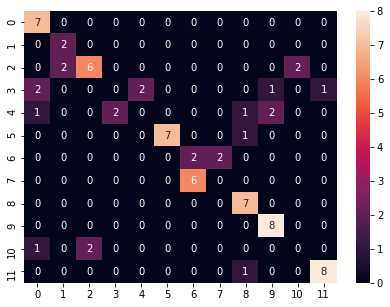

In [493]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Acc Treino: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Acc Teste:  {:.4f}".format(accuracy))


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


df_cm = pd.DataFrame(cm)
plt.figure(figsize = (7, 5))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
index_test = 58
X_valid = df.iloc[index_test].texto_limpo
X_valid = vectorizer.transform([X_valid])

predicted = model.predict(X_valid)
print(predicted.argmax(axis=-1))
print( encoder.inverse_transform(predicted) )
print(df.iloc[index_test].tipo)

In [496]:
df.iloc[index_test]


Unnamed: 0                                                                   43
projeto                                     Campo Mourão - proj 86 - processo 1
texto                         MUNICÍPIO DE CAMPO MOURÃO ESTADO DO PARANÁ    ...
tipo                                              Parecer Jurídico do Município
texto_limpo                   município campo mourão estado paraná assunto a...
texto_stemmed                 municípi camp mour est paran assunt anális min...
texto_len                                                                  4976
texto_limpo_len                                                            3829
texto_stemmed_len                                                          2868
qtd_palavras_texto                                                          762
qtd_palavras_texto_limpo                                                    461
qtd_palavras_texto_stemmed                                                  461
Name: 43, dtype: object